<h1 style="text-align: center;">
    Assignment 4: Segmentation and CLIP
</h1>
<div style="text-align: right;"> <b>
    Name: Tejas Srivastava <br>
    Roll No.: 2021102017
</div>


# Image Segmentation using U-Net [4 points]

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Define root directory
root_dir = '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive


# 1.) Data Preparation

### Code to download the dataset.
The dataset is downloaded, and then uploaded on google drive, which is mounted on the google colab runtime-environment, and used for training.

In [ ]:
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

In [ ]:
data_dir = os.path.join(root_dir,"cityscapes_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2980 500


/content/drive/My Drive/Colab Notebooks/cityscapes_data/train/2786.jpg


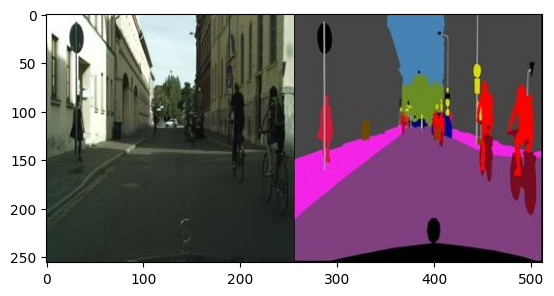

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [ ]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

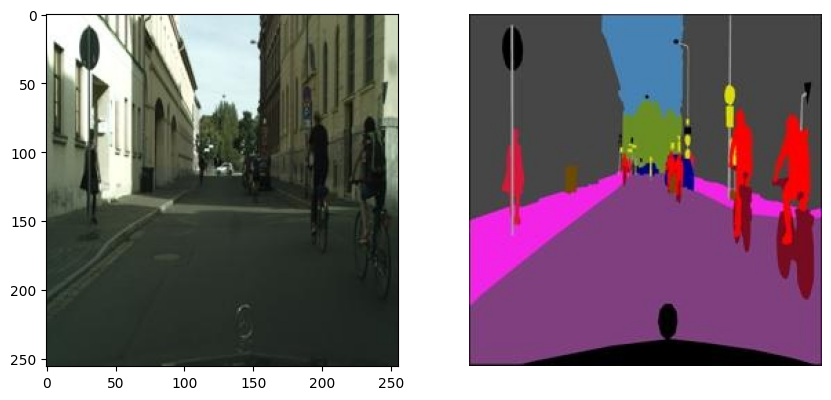

In [ ]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
plt.axis('off')
plt.show()

# Define labels (using clustering)

In [ ]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)


(1000, 3)


In [ ]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

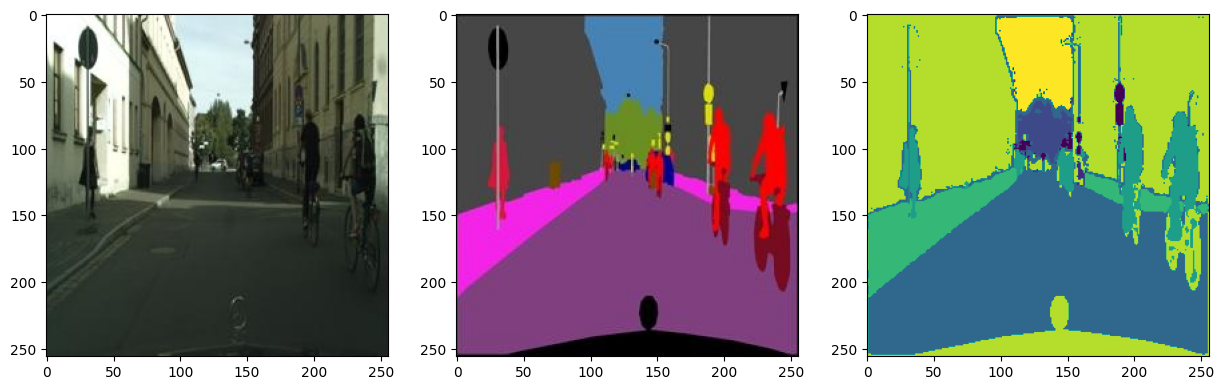

In [ ]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)


# Define dataset

In [ ]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)


In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2980


In [ ]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)


torch.Size([3, 256, 256]) torch.Size([256, 256])


# Define Model Architecture

In [ ]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out


In [ ]:
model = UNet(num_classes=num_classes)

In [ ]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

# iterating through the dataloader
for X, Y in data_loader:
    print(X.shape, Y.shape)
    break


2980 745
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# Training the model

In [ ]:
batch_size = 16
epochs = 1
lr = 0.01

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)


In [ ]:
model = UNet(num_classes = num_classes).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

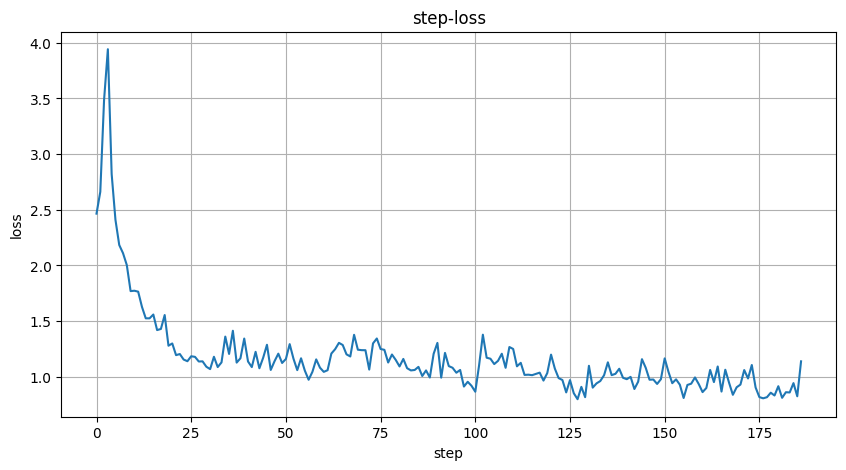

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
axes.plot(step_losses)
plt.grid()
plt.title("step-loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

# Saving the trained model

In [ ]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
print("Epoch loss : ",epoch_losses)

Epoch loss :  [1.1747562955407536]


# Checking model predictions

In [ ]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [ ]:

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []
Miou_scores = []


for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    # mIOU score
    miou_score = calculate_mean_iou_per_image(label_class, label_class_predicted)
    Miou_scores.append(miou_score)


    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("IoU score : ",sum(iou_scores) / len(iou_scores))
mIoU = np.mean(np.array(Miou_scores))
print("MIoU score : ",mIoU)



IoU score :  0.9848190307617187
MIoU score :  0.24732560329925626


# 2.) Importance of skip connections.
Skip connections in the U-net architecture play a crucial role in achieving better segmentation results.

## Problem with Deep Networks:

- **Loss of Spatial Information:** As convolutional layers in the encoder pathway of U-net process the image, they capture high-level features but often lose precise spatial information about the image's details. This information is crucial for accurate segmentation of objects with intricate boundaries.

## How Skip Connections Help:


- **Preserving Spatial Details:** Skip connections directly connect corresponding layers in the encoder and decoder pathways of U-net. These connections bypass some convolutional layers, allowing the model to transfer spatial information (like object edges and shapes) directly from the encoder to the decoder.
- **Enhanced Feature Fusion:** In the decoder, these spatial details from the encoder are fused with the high-level semantic features extracted by the deeper convolutional layers. This combination creates a richer feature map for the decoder, enabling it to make more precise predictions for each pixel's class label (e.g., building, road, sky).

## Benefits of Skip Connections:

- **Improved Segmentation Accuracy:** By preserving spatial details, skip connections allow the model to better segment objects with complex shapes and fine boundaries. This is particularly important for tasks like cityscapes segmentation where precise delineation of buildings, roads, and other urban elements is crucial.

- **Reduced Training Time:** By providing the decoder with relevant spatial information early on, skip connections can help the model converge faster during training. The decoder doesn't need to "re-learn" these details from scratch, leading to potentially faster training times.


*Skip connections bridge the gap between high-level features and precise spatial information in U-net. This allows the model to make more accurate predictions for each pixel, resulting in better segmentation performance on tasks like cityscapes image segmentation.*


# Model Architecture without skip connections

In [ ]:
class UNet_non_skip(nn.Module):

    def __init__(self, num_classes):
        super(UNet_non_skip, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out


# Training the new model

In [ ]:
model = UNet_non_skip(num_classes=num_classes)

In [ ]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

# iterating through the dataloader
for X, Y in data_loader:
    print(X.shape, Y.shape)
    break


500 125
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [ ]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [ ]:
batch_size = 16
epochs = 1
lr = 0.01

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)


In [ ]:
model = UNet_non_skip(num_classes = num_classes).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

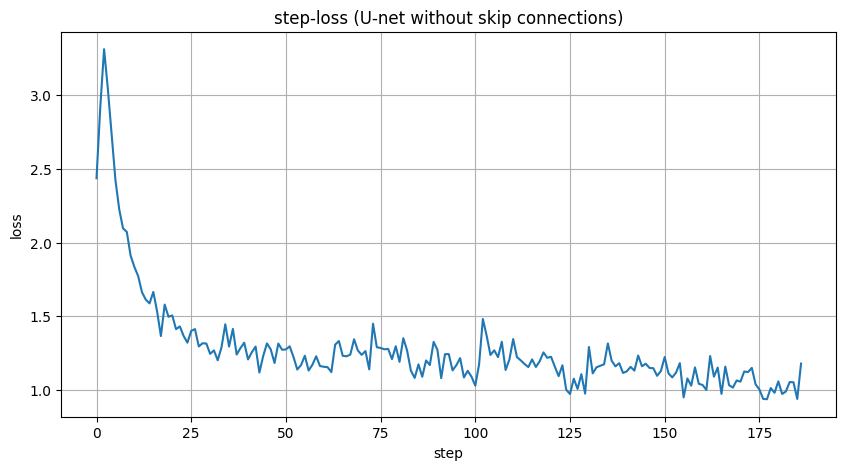

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
axes.plot(step_losses)
plt.grid()
plt.title("step-loss (U-net without skip connections)")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

In [ ]:
model_name = "U-Net_non_skip.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
print("Epoch loss : ",epoch_losses)

Epoch loss :  [1.2807502325843363]


# Checking predictions (U-net without skip connections)

In [ ]:
model_path = "U-Net_non_skip.pth"
model_ = UNet_non_skip(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []
Miou_scores = []


for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    # mIOU score
    miou_score = calculate_mean_iou_per_image(label_class, label_class_predicted)
    Miou_scores.append(miou_score)


    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("IoU score : ",sum(iou_scores) / len(iou_scores))
mIoU = np.mean(np.array(Miou_scores))
print("MIoU score : ",mIoU)



IoU score :  0.9848190307617187
MIoU score :  0.17474500391465017


## Analysis of IoU scores.

- No! The new model whithout skp-connections does not perform better than the original model.

- The IoU score without skip connections (calculated using metric given by code) and that with skip connections are approximately same. However, since this IoU is not a good metric of segmentation, (as explained in the next part), the comparison boils down to the MIoU score implemented.

- For the MIoU score, the Unet with skip connections give `0.24732560329925626` while the Unet without skip connections give only `0.17474500391465017`. Qualitatively also, the differences are stark and observable, the segmentation turns out to just 3 or 4 classes with bad IoU for each class when using Unet without skip connection. The individual segments  (roads, dividers, cars) cannot be made out using this model. The segments merge into each other to form larger classes with larger area and thus are not distinguishable visually.

- However, the results obtained from the original UNet, give good and sufficient results. The individual segments like cars, trees roads and dividers are clearly distinguishable and can be used in real-life applications to a much larger extent than the above model.

# 2.) Proper metric (Mean IoU per class)

The issue with the metric implemented in the current form is that it calculates the Intersection over Union (IoU) score without considering individual classes. Instead, it computes the IoU score globally for all classes combined, which can lead to misleading results, especially in scenarios where there is class imbalance or variations in the sizes of different classes.

- **Global IoU Calculation:** The metric calculates the intersection and union of all pixels in the segmentation masks without distinguishing between different classes. This means that the IoU score represents the overlap between all classes combined, rather than the overlap specific to each class.

- **Class Imbalance:** If there is class imbalance in the dataset, where some classes are more prevalent than others, the global IoU score may be dominated by the more frequent classes. As a result, the metric may not accurately reflect the segmentation performance of individual classes.

- **Varied Class Sizes:** In cases where different classes have varied sizes or spatial extents, the global IoU score may be influenced by the classes with larger or more spatially extensive segmentation regions. This can skew the overall evaluation of segmentation performance, particularly for smaller or less prevalent classes.


***The new function addresses the issue by calculating the Intersection over Union (IoU) score separately for each class, rather than computing a global IoU score for all classes combined.***

- The function `calculate_iou_per_class` iterates over each class in the segmentation masks and computes the intersection and union for that particular class. This means that the IoU score is calculated individually for each class, providing insights into how well the model segments each class.

- By calculating IoU scores separately for each class, the metric accounts for class imbalance in the dataset. This ensures that the evaluation is not dominated by the performance of more prevalent classes, and it provides a fair assessment of segmentation accuracy across all classes.

- Since the IoU score is computed independently for each class, variations in class sizes or spatial extents do not affect the evaluation of other classes. Each class is evaluated based on its own segmentation region, allowing for a more accurate assessment of segmentation performance.

- The function `calculate_mean_iou_per_image` computes the mean IoU score across all classes for a single image. This provides a summary measure of segmentation performance for that particular image, taking into account the IoU scores of all individual classes.


***Is the mIoU score different between the model with and without skip connections? Explain why?***
Yes, the MIoU scores and IoU scores obtained are different. Since the MIoU score is a better metric for the segmentation task, and observing from the output segmented labels of 10 images, the MIoU score actually should be lower than the IoU scores obtained. And the same is observed, since the MiOU score of the non-skip connections Unet (`0.17474500391465017`) is smaller than the MIoU score of the original model (`0.24732560329925626`). Such a difference is not observable in the case of pre-implemented IoU score, thus showing that again, the IoU implemented is not a good metric of the task and has some shortcomings.

In [ ]:
def calculate_iou_per_class(label_class, label_class_predicted):
    num_classes = max(label_class.max(), label_class_predicted.max()) + 1
    iou_scores = []

    for cls in range(num_classes):
        intersection = np.logical_and(label_class == cls, label_class_predicted == cls)
        union = np.logical_or(label_class == cls, label_class_predicted == cls)

        iou_score = np.sum(intersection) / (np.sum(union) + 1e-10)  # Adding epsilon to avoid division by zero
        iou_scores.append(iou_score)

    return iou_scores

def calculate_mean_iou_per_image(label, label_predicted):
    mean_iou = np.mean(calculate_iou_per_class(label, label_predicted))
    return mean_iou


### Note : the results of the new metric can be seen as output cells in the part 2